# Working with Pydantic in Pixeltable

Pixeltable's Pydantic integration enables type-safe data insertion using Pydantic models. Instead of inserting raw dictionaries, you can define structured models with validation and insert them directly into Pixeltable tables.

### Benefits

- **Type Safety**: Pydantic validates data before insertion
- **IDE Support**: Autocomplete and type hints for your data
- **Self-Documenting**: Models serve as schema documentation
- **Validation**: Built-in data validation via Pydantic

### Important notes

- Pydantic model fields map to Pixeltable columns by name
- Computed columns are automatically skipped during insertion
- Nested Pydantic models map to JSON columns

In [ ]:
%pip install -qU pixeltable pydantic

In [1]:
import pixeltable as pxt

pxt.drop_dir('pydantic_demo', force=True)
pxt.create_dir('pydantic_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'pydantic_demo'.


## Basic usage: scalar types

Define a Pydantic model with fields that match your table columns. Pixeltable automatically maps Python types to Pixeltable types:

| Python Type | Pixeltable Type |
|-------------|-----------------|
| `str` | `pxt.String` |
| `int` | `pxt.Int` |
| `float` | `pxt.Float` |
| `bool` | `pxt.Bool` |
| `datetime.datetime` | `pxt.Timestamp` |
| `Literal[...]` | `pxt.String` or `pxt.Int` |
| `Enum` | Based on enum value type |

In [2]:
import datetime
from enum import Enum
from typing import Literal

import pydantic

# Define an enum for product categories


class Category(Enum):
    ELECTRONICS = 1
    CLOTHING = 2
    BOOKS = 3


# Define a Pydantic model


class Product(pydantic.BaseModel):
    name: str
    price: float
    in_stock: bool
    category: Category
    rating: Literal['poor', 'average', 'good', 'excellent']
    created_at: datetime.datetime
    description: str | None = None  # Optional field

In [3]:
# Create a table with matching schema
products = pxt.create_table(
    'pydantic_demo/products',
    {
        'name': pxt.Required[pxt.String],
        'price': pxt.Required[pxt.Float],
        'in_stock': pxt.Required[pxt.Bool],
        'category': pxt.Required[pxt.Int],  # Enum values are integers
        'rating': pxt.Required[pxt.String],  # Literal values
        'created_at': pxt.Required[pxt.Timestamp],
        'description': pxt.String,  # Nullable
    },
)

Created table 'products'.


In [4]:
# Create Pydantic model instances
now = datetime.datetime.now()

product_data = [
    Product(
        name='Wireless Headphones',
        price=79.99,
        in_stock=True,
        category=Category.ELECTRONICS,
        rating='excellent',
        created_at=now,
        description='High-quality wireless headphones with noise cancellation',
    ),
    Product(
        name='Python Cookbook',
        price=49.99,
        in_stock=True,
        category=Category.BOOKS,
        rating='good',
        created_at=now,
    ),
    Product(
        name='Running Shoes',
        price=129.99,
        in_stock=False,
        category=Category.CLOTHING,
        rating='average',
        created_at=now,
        description='Lightweight running shoes',
    ),
]

# Insert Pydantic models directly
products.insert(product_data)
products.collect()

Inserted 3 rows with 0 errors in 0.02 s (146.18 rows/s)


name,price,in_stock,category,rating,created_at,description
Wireless Headphones,79.99,True,1,excellent,2026-01-22 17:17:05.519004-08:00,High-quality wireless headphones with noise cancellation
Python Cookbook,49.99,True,3,good,2026-01-22 17:17:05.519004-08:00,None
Running Shoes,129.99,False,2,average,2026-01-22 17:17:05.519004-08:00,Lightweight running shoes


## Nested models and JSON columns

Nested Pydantic models automatically map to Pixeltable JSON columns. This is useful for storing structured metadata.

In [5]:
# Define nested models
class Address(pydantic.BaseModel):
    street: str
    city: str
    country: str
    zip_code: str


class ContactInfo(pydantic.BaseModel):
    email: str
    phone: str | None = None
    address: Address


class Customer(pydantic.BaseModel):
    customer_id: str
    name: str
    contact: ContactInfo  # Nested model → JSON column

In [6]:
# Create table with JSON column for nested data
customers = pxt.create_table(
    'pydantic_demo/customers',
    {
        'customer_id': pxt.Required[pxt.String],
        'name': pxt.Required[pxt.String],
        'contact': pxt.Required[pxt.Json],  # Nested model stored as JSON
    },
)

Created table 'customers'.


In [7]:
# Insert nested data
customer_data = [
    Customer(
        customer_id='C001',
        name='Alice Johnson',
        contact=ContactInfo(
            email='alice@example.com',
            phone='+1-555-0101',
            address=Address(
                street='123 Main St',
                city='San Francisco',
                country='USA',
                zip_code='94102',
            ),
        ),
    ),
    Customer(
        customer_id='C002',
        name='Bob Smith',
        contact=ContactInfo(
            email='bob@example.com',
            address=Address(
                street='456 Oak Ave',
                city='New York',
                country='USA',
                zip_code='10001',
            ),
        ),
    ),
]

customers.insert(customer_data)
customers.collect()

Inserted 2 rows with 0 errors in 0.01 s (227.55 rows/s)


customer_id,name,contact
C001,Alice Johnson,"{""email"": ""alice@example.com"", ""phone"": ""+1-555-0101"", ""address"": {""city"": ""San Francisco"", ""street"": ""123 Main St"", ""country"": ""USA"", ""zip_code"": ""94102""}}"
C002,Bob Smith,"{""email"": ""bob@example.com"", ""phone"": null, ""address"": {""city"": ""New York"", ""street"": ""456 Oak Ave"", ""country"": ""USA"", ""zip_code"": ""10001""}}"


In [8]:
# Query nested JSON fields using Pixeltable's JSON path syntax
customers.select(
    customers.name,
    email=customers.contact.email,
    city=customers.contact.address.city,
).collect()

name,email,city
Alice Johnson,alice@example.com,San Francisco
Bob Smith,bob@example.com,New York


## Media files with Pydantic

For media columns (Image, Video, Audio, Document), use `str` or `Path` fields in your Pydantic model to specify file paths or URLs.

In [9]:
from pathlib import Path


class ImageRecord(pydantic.BaseModel):
    title: str
    image_url: str  # URLs or file paths as strings
    tags: list[str]


# Create table with Image column
images = pxt.create_table(
    'pydantic_demo/images',
    {
        'title': pxt.Required[pxt.String],
        'image_url': pxt.Required[pxt.Image],  # Media column
        'tags': pxt.Required[pxt.Json],
    },
)

Created table 'images'.


Inserted 1 row with 0 errors in 0.27 s (3.74 rows/s)


title,image_url,tags
Sample Image,,"[""sample"", ""test"", ""image""]"

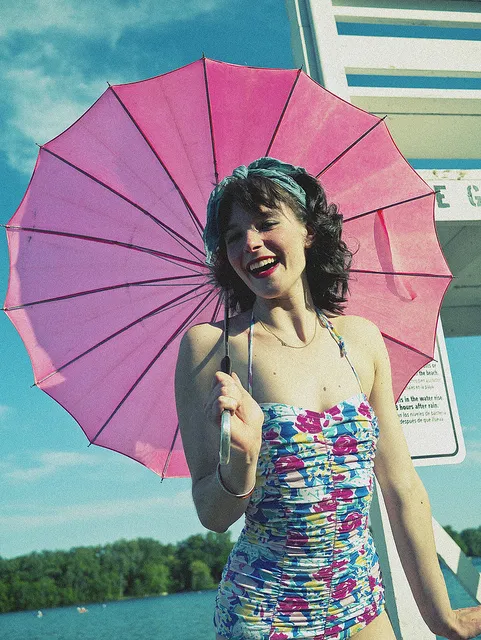

In [10]:
# Insert image records with URLs
base_url = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images'
image_data = [
    ImageRecord(
        title='Sample Image',
        image_url=f'{base_url}/000000000036.jpg',
        tags=['sample', 'test', 'image'],
    )
]

images.insert(image_data)
images.select(images.title, images.image_url, images.tags).collect()

## Working with Computed Columns

Pydantic models work seamlessly with computed columns. Simply omit computed column fields from your model - Pixeltable will skip them during insertion.

In [11]:
# Model only includes input columns
class Article(pydantic.BaseModel):
    title: str
    content: str


# Create table with computed column
articles = pxt.create_table(
    'pydantic_demo/articles',
    {
        'title': pxt.Required[pxt.String],
        'content': pxt.Required[pxt.String],
    },
)

# Add a computed column
articles.add_computed_column(
    word_count=articles.content.apply(
        lambda x: len(x.split()), col_type=pxt.Int
    )
)

Created table 'articles'.
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [12]:
# Insert data - computed columns are automatically calculated
article_data = [
    Article(
        title='Getting Started with Pixeltable',
        content='Pixeltable is a powerful tool for building AI applications. It provides automatic versioning and incremental computation.',
    ),
    Article(
        title='Type Safety in Python',
        content='Using Pydantic with Pixeltable provides type safety and validation for your data pipelines.',
    ),
]

articles.insert(article_data)
articles.select(articles.title, articles.word_count).collect()

Inserted 2 rows with 0 errors in 0.01 s (186.43 rows/s)


title,word_count
Getting Started with Pixeltable,16
Type Safety in Python,13


## Optional Fields and Defaults

Pydantic's optional fields with defaults work naturally with Pixeltable's nullable columns.

In [13]:
class Task(pydantic.BaseModel):
    title: str
    priority: int = 1  # Default value
    due_date: datetime.datetime | None = None  # Optional
    notes: str | None = None  # Optional


tasks = pxt.create_table(
    'pydantic_demo/tasks',
    {
        'title': pxt.Required[pxt.String],
        'priority': pxt.Required[pxt.Int],
        'due_date': pxt.Timestamp,  # Nullable
        'notes': pxt.String,  # Nullable
    },
)

# Insert with and without optional fields
tasks.insert(
    [
        Task(
            title='Complete project',
            priority=3,
            due_date=datetime.datetime(2025, 12, 31),
        ),
        Task(
            title='Review code'
        ),  # Uses default priority=1, None for optionals
        Task(title='Write docs', notes='Include examples'),
    ]
)

tasks.collect()

Created table 'tasks'.
Inserted 3 rows with 0 errors in 0.01 s (408.88 rows/s)


title,priority,due_date,notes
Complete project,3,2025-12-31 00:00:00-08:00,None
Review code,1,NaT,None
Write docs,1,NaT,Include examples


## Type Mapping Reference

Here's the complete mapping between Pydantic/Python types and Pixeltable types:

| Pydantic Field Type | Pixeltable Column Type | Notes |
|---------------------|------------------------|-------|
| `str` | `pxt.String` | Basic string |
| `int` | `pxt.Int` | 64-bit integer |
| `float` | `pxt.Float` | 64-bit float |
| `bool` | `pxt.Bool` | Boolean |
| `datetime.datetime` | `pxt.Timestamp` | With timezone support |
| `Literal['a', 'b']` | `pxt.String` | String literals |
| `Literal[1, 2, 3]` | `pxt.Int` | Integer literals |
| `Enum` | `pxt.Int` or `pxt.String` | Based on enum values |
| `T \| None` | Nullable column | Optional fields |
| Nested `BaseModel` | `pxt.Json` | Must be JSON-serializable |
| `list[T]` | `pxt.Json` | Lists stored as JSON |
| `dict[str, T]` | `pxt.Json` | Dicts stored as JSON |
| `str` (for media) | `pxt.Image`, `pxt.Video`, etc. | File paths or URLs |

## Learn More

For more information about working with Pydantic in Pixeltable:

- [Pixeltable Documentation](https://docs.pixeltable.com)
- [Pydantic Documentation](https://docs.pydantic.dev)
- [Type Safety Blog Post](https://www.pixeltable.com/blog/pydantic-integration-type-safety)

If you have any questions, don't hesitate to reach out on [Discord](https://discord.com/invite/QPyqFYx2UN).